In [7]:
# --- IMPORTS --------------------------------------------------------------------- #
import pandas as pd                                                                 #
import matplotlib.pyplot as plt     # plots                                         #
import pandas as pd                 # data processing                               #
import numpy as np                  # number processing                             #
import folium                       # easy maps, also interactive                   #
from folium.features import DivIcon # needed for map labels                         #    
import glob                         # glob2                                         #
import re                           # regix package, for following three functions  #
# --------------------------------------------------------------------------------- #

# --- FUNCTIONS ------------------------------------------------------------------- #
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.
    >>> alphanum_key("z23a")
    ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

def process_data(raw_data, column_names, date_start, date_end, resample_freq,encoding,header,data_type):
    """
    Processes the .csv data files. Outputs all as df and resampled as df_resampled.
    """
    data_list = []
    for x in raw_data:
        loop = pd.read_csv(x, sep=',', names=column_names, header=header, na_values='NaN',encoding=encoding, parse_dates=[0])
        data_list.append(loop)
    
    df = pd.concat(data_list, ignore_index=True)
    df = df.set_index('time')
    df = df.loc[date_start:date_end]
    df_resampled = df.astype(data_type).resample(resample_freq).mean()
    
    return df_resampled

def alphanum_key_second(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def initial_data_ingestion(data_path):
    """
    Use glob to make list of all data files to process
    """
    datlog_raw  = sorted(glob.glob(data_path + 'B*.dat'), key=alphanum_key_second)
    exo_raw     = sorted(glob.glob(data_path + 'E*.dat'), key=alphanum_key_second)
    ms3_raw     = sorted(glob.glob(data_path + 'M*.dat'), key=alphanum_key_second)
    ws_raw      = sorted(glob.glob(data_path + 'W*.dat'), key=alphanum_key_second)
    paraq1_raw  = sorted(glob.glob(data_path + 'PAR_aqua1*.dat'), key=alphanum_key_second)
    paraq2_raw  = sorted(glob.glob(data_path + 'PAR_aqua2*.dat'), key=alphanum_key_second)
    paratmo_raw = sorted(glob.glob(data_path + 'PAR_atmo*.dat'), key=alphanum_key_second)
    
    return datlog_raw, exo_raw, ms3_raw, ws_raw, paraq1_raw, paraq2_raw, paratmo_raw

def save_close_plot(fig, filename):
    fig.savefig(filename)
    plt.close(fig)



########################################
# -------- CHANGE THESE THINGS ------- #
start_time  = '2023-05-30'    
end_time    = '2023-06-03'    
data_path   = '../python_code/data/'
# path is folder where data is located (will make .py ask eventually)
# path works best as an absolute file path
# ------------------------------------ #
########################################

# get filenames from .csv files
datlog_raw, exo_raw, ms3_raw, ws_raw, paraq1_raw, paraq2_raw, paratmo_raw = initial_data_ingestion(data_path)

# Process Datalogger data
datlog_column_names = ['time', 'record', 'BattV', 'PTemp']
datlog_hr = process_data(datlog_raw, datlog_column_names,start_time,end_time, '1H','',3,'float')

# Process MET STATION data
met_column_names = ['time', 'record', 'BP', 'RH', 'AirTemp', 'DP']
met_hr = process_data(ms3_raw, met_column_names,start_time,end_time, '1H','',3,'float')
met_hhr = process_data(ms3_raw, met_column_names,start_time,end_time, '30MIN','',3,'float')

# Process WS data
ws_column_names = ['time', 'record', 'fWSV1', 'fWSV2', 'fWSV3', 'fWSC', 'iWSDiag', 'iWSValue']
ws_2hr = process_data(ws_raw, ws_column_names,start_time,end_time, '2H','',3,'float')
ws_hhr = process_data(ws_raw, ws_column_names,start_time,end_time, '30MIN','',3,'float')

# Process EXO data
exo_column_names = ["time","record","Chloro","nLFCond","Pressure",
                    "Turbidity","Temp","Cond","D_OX","Sal","TSS","VerticalPosition",
                    "Depth","D_OX2","SpCond","WiperPosition","BPower","fDOM","D_OX3",
                    "Phycoerythrin","pH","CablePower","fDOM2","ORP","TDS","pH2"]
exo_hr = process_data(exo_raw, exo_column_names,start_time,end_time, '1H','',2,'float')

# Process PAR data
par_column_names = ["time", "record", "PAR_Den", "PAR_Tot"]
# Process PAR top data
aq1 = process_data(paraq1_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')

# Process PAR bottom data
aq2 = process_data(paraq2_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')

# Process PAR atmo data
at3 = process_data(paratmo_raw, par_column_names,start_time,end_time, '1H','utf-8',3,'int64')



# save_close_plot(fig, 'datalogger_plot.jpg')


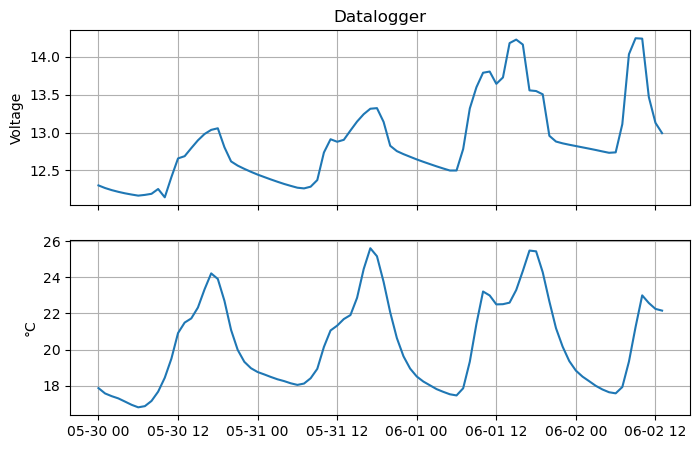

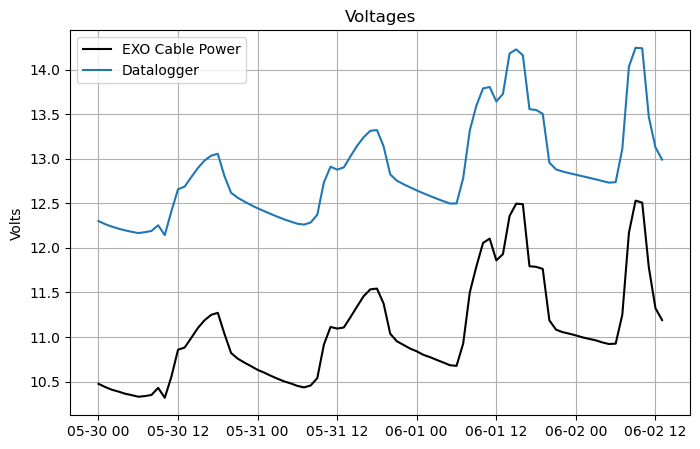

In [10]:
# plot datalogger votlage and panel temp
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(8,5),sharex=True)
ax[0].set_title('Datalogger')

ax[0].plot(datlog_hr.index,datlog_hr.BattV)
ax[0].set_ylabel('Voltage')
ax[0].grid()

ax[1].plot(datlog_hr.index,datlog_hr.PTemp)
ax[1].set_ylabel('\u00b0C')
ax[1].grid()

# plot datalogger and exo cable voltage 
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(exo_hr.index,exo_hr.CablePower,label='EXO Cable Power',color='black')
ax.plot(datlog_hr.index,datlog_hr.BattV,label='Datalogger')
ax.legend()
ax.set_ylabel('Volts')
ax.set_title('Voltages')
ax.grid();

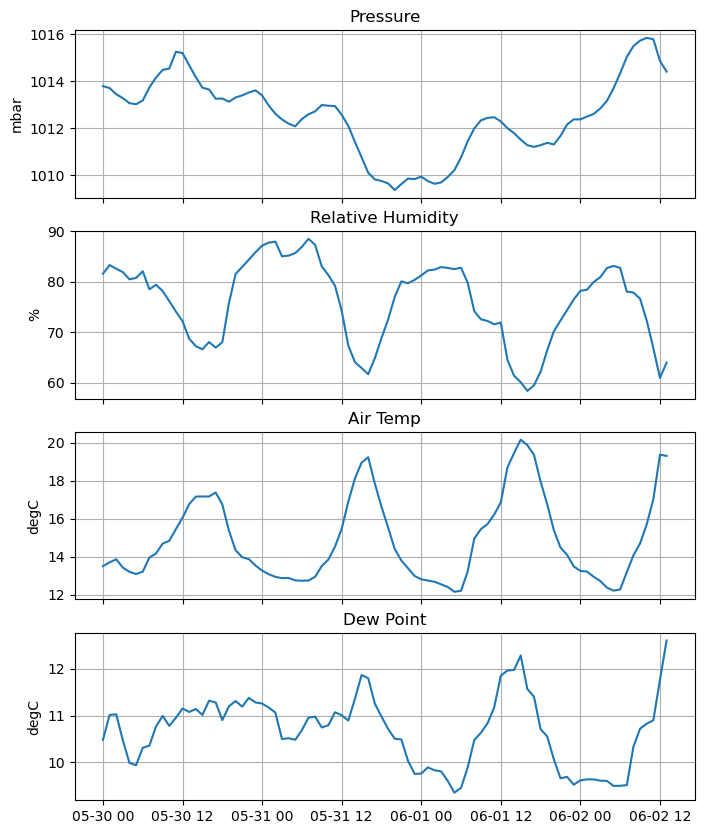

In [16]:
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=True)

ax[0].plot(met_hr.index,met_hr.BP)
ax[0].set_ylabel('mbar')
ax[0].set_title('Pressure')

ax[1].plot(met_hr.index,met_hr.RH)
ax[1].set_ylabel('%')
ax[1].set_title('Relative Humidity')

ax[2].plot(met_hr.index,met_hr.AirTemp)
ax[2].set_ylabel('degC')
ax[2].set_title('Air Temp')

ax[3].plot(met_hr.index,met_hr.DP)
ax[3].set_ylabel('degC')
ax[3].set_title('Dew Point')

ax[0].grid(),ax[1].grid(),ax[2].grid(),ax[3].grid();

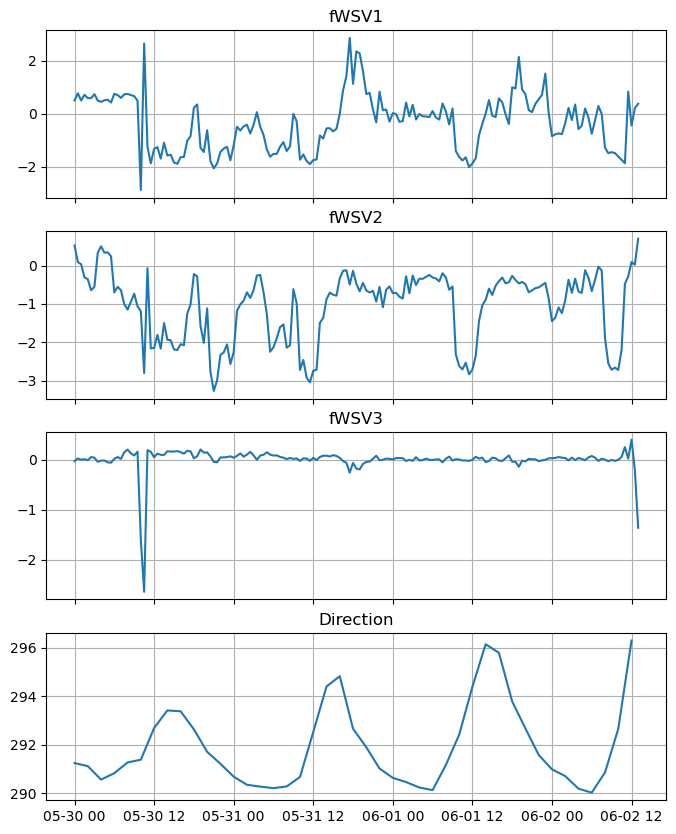

In [17]:
fig,ax=plt.subplots(ncols=1,nrows=4,figsize=(8,10),sharex=True)

ax[0].plot(ws_hhr.index,ws_hhr.fWSV1)
#ax[0].set_ylabel('Wind Speed') dunno
ax[0].set_title('fWSV1')

ax[1].plot(ws_hhr.index,ws_hhr.fWSV2)
ax[1].set_title('fWSV2')

ax[2].plot(ws_hhr.index,ws_hhr.fWSV3)
ax[2].set_title('fWSV3')

ax[3].plot(ws_2hr.index,ws_2hr.fWSC)
ax[3].set_title('Direction')

ax[0].grid(),ax[1].grid(),ax[2].grid(),ax[3].grid();

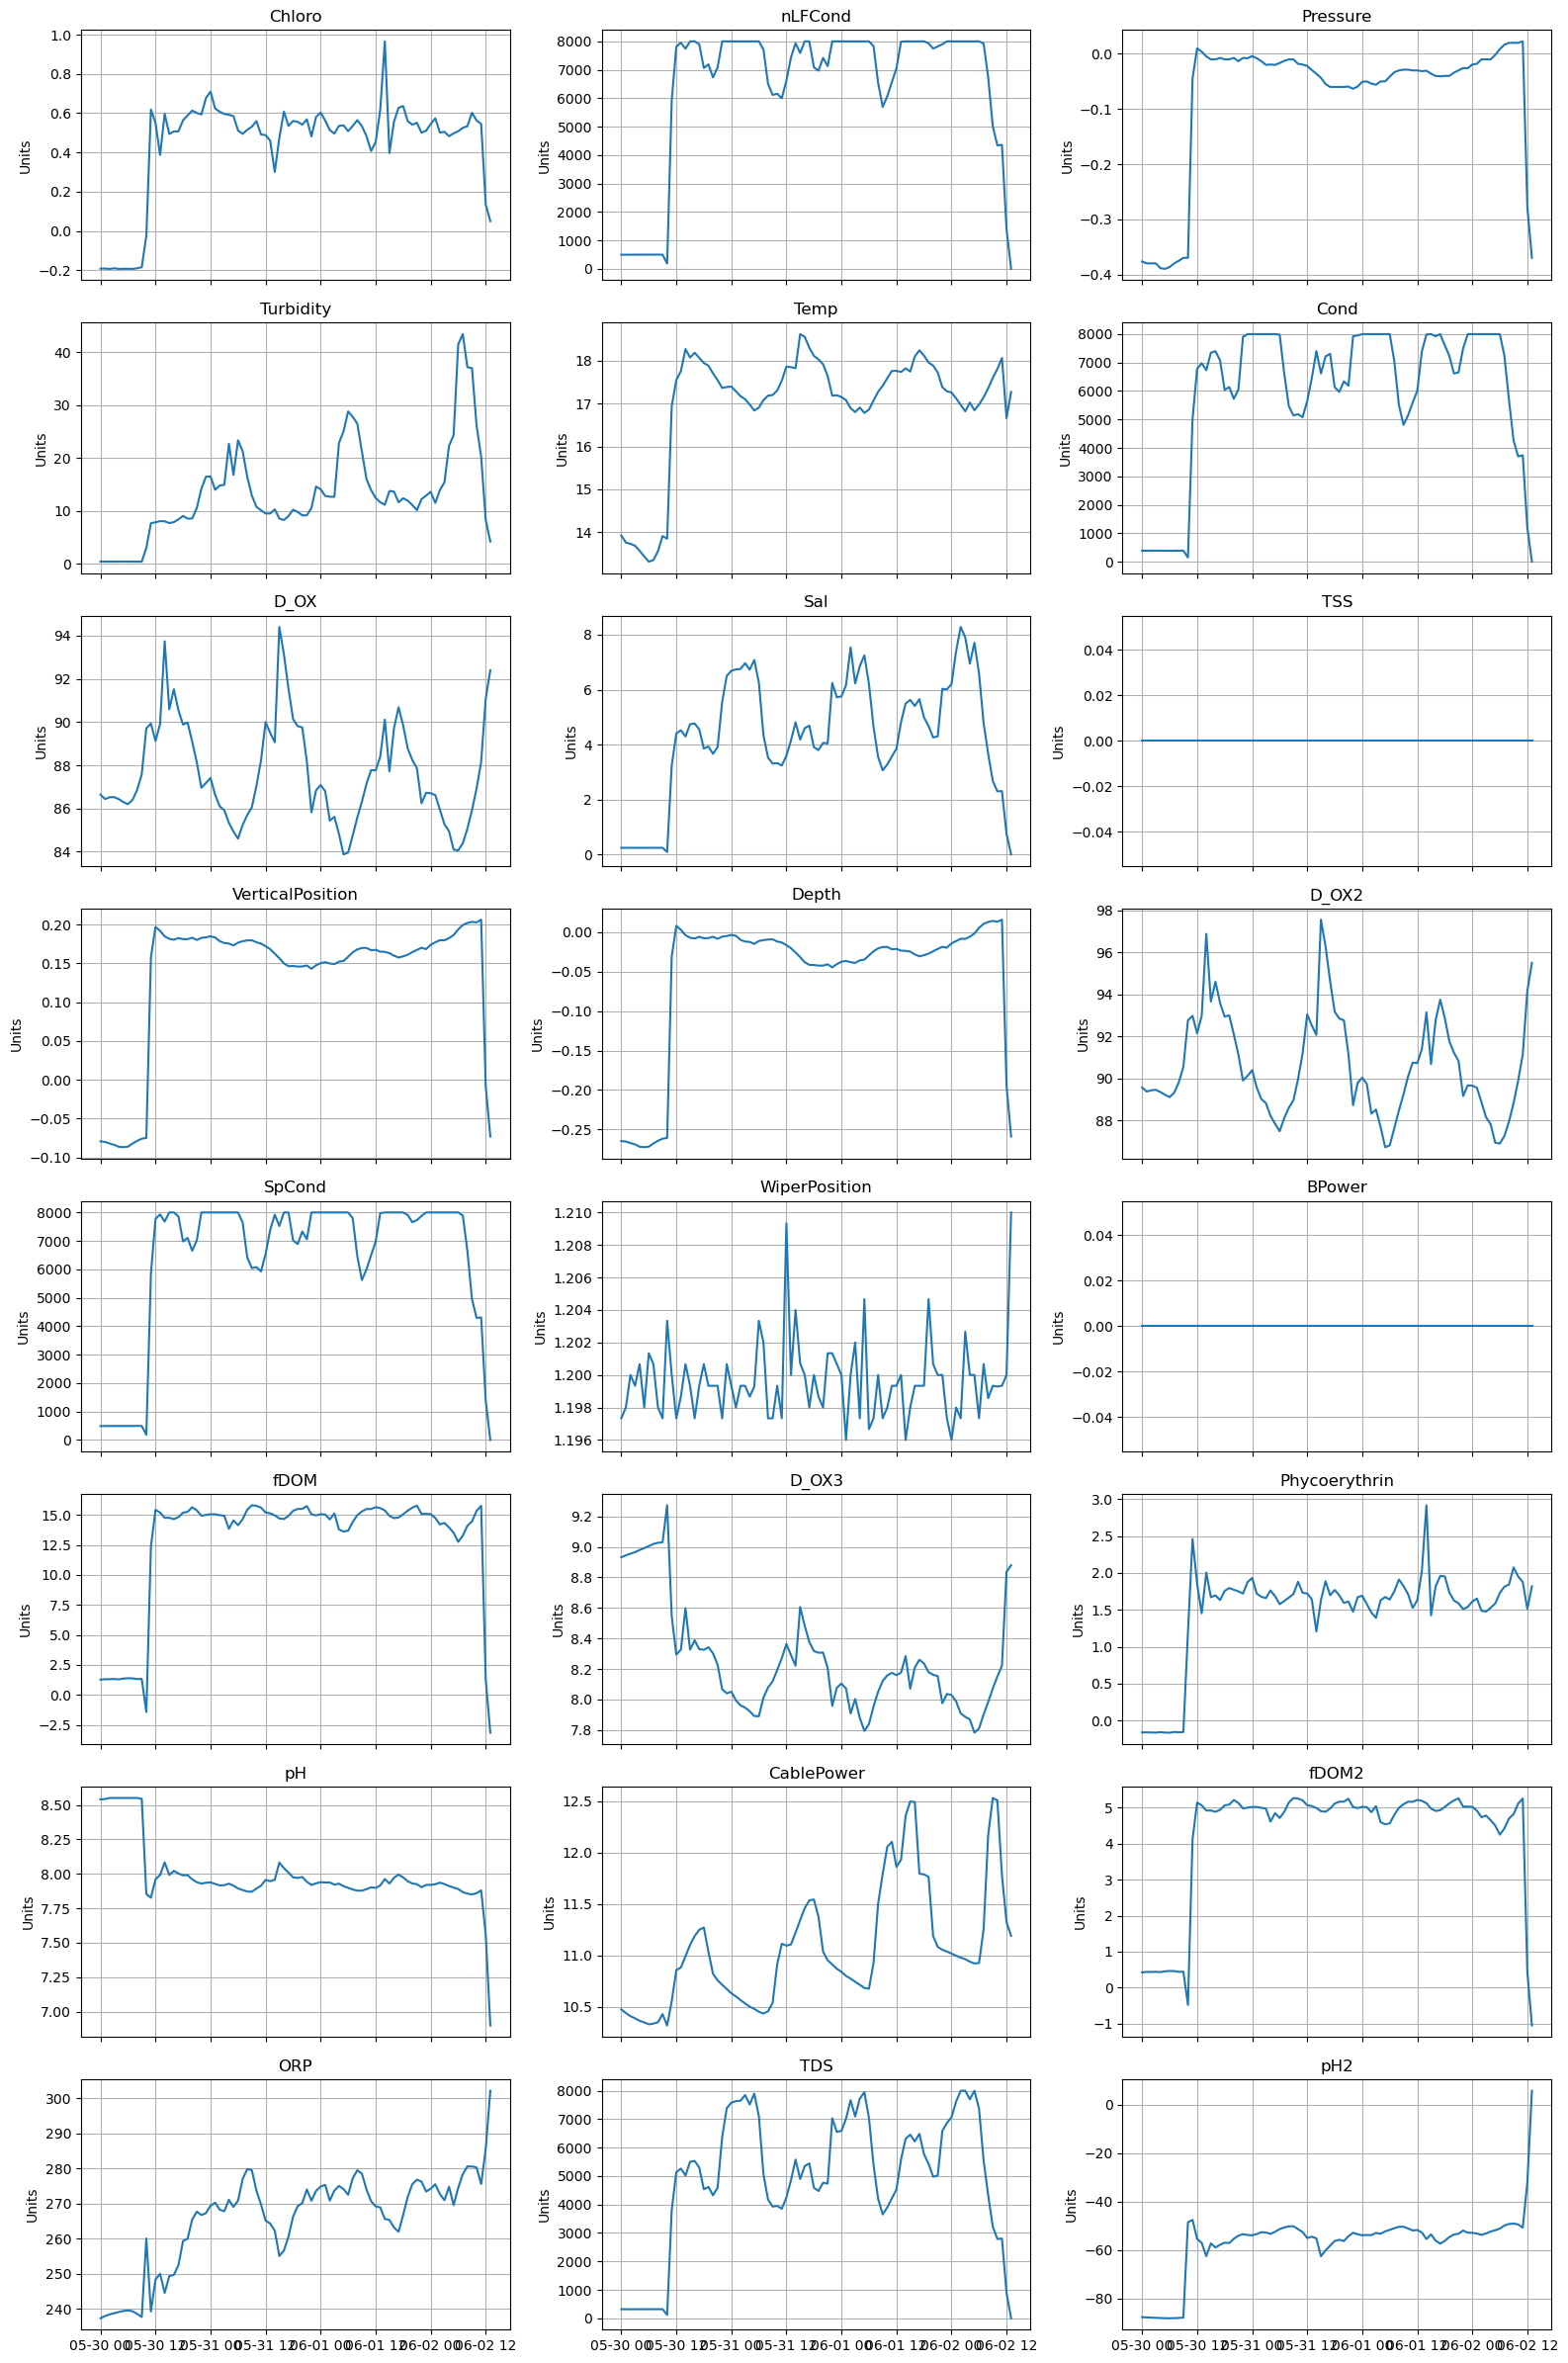

In [50]:
import matplotlib.dates as mdates
# List of variables to plot
exo_plot_variables = ['Chloro', 'nLFCond', 'Pressure', 'Turbidity', 'Temp', 'Cond', 'D_OX', 'Sal',
             'TSS', 'VerticalPosition', 'Depth', 'D_OX2', 'SpCond', 'WiperPosition',
             'BPower', 'fDOM', 'D_OX3', 'Phycoerythrin', 'pH', 'CablePower', 'fDOM2',
             'ORP', 'TDS', 'pH2']

num_variables = 24 #(or do len(exo_plot_variables))
cols = 3
rows = 8

fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 3 * rows), sharex=True)

for i, var in enumerate(exo_plot_variables):
    row = i // cols
    col = i % cols
    ax[row, col].plot(exo_hr.index, getattr(exo_hr, var))
    ax[row, col].set_ylabel('Units')  # Adjust units for each variable
    ax[row, col].set_title(var)
    ax[row, col].grid()

plt.tight_layout()
plt.show()

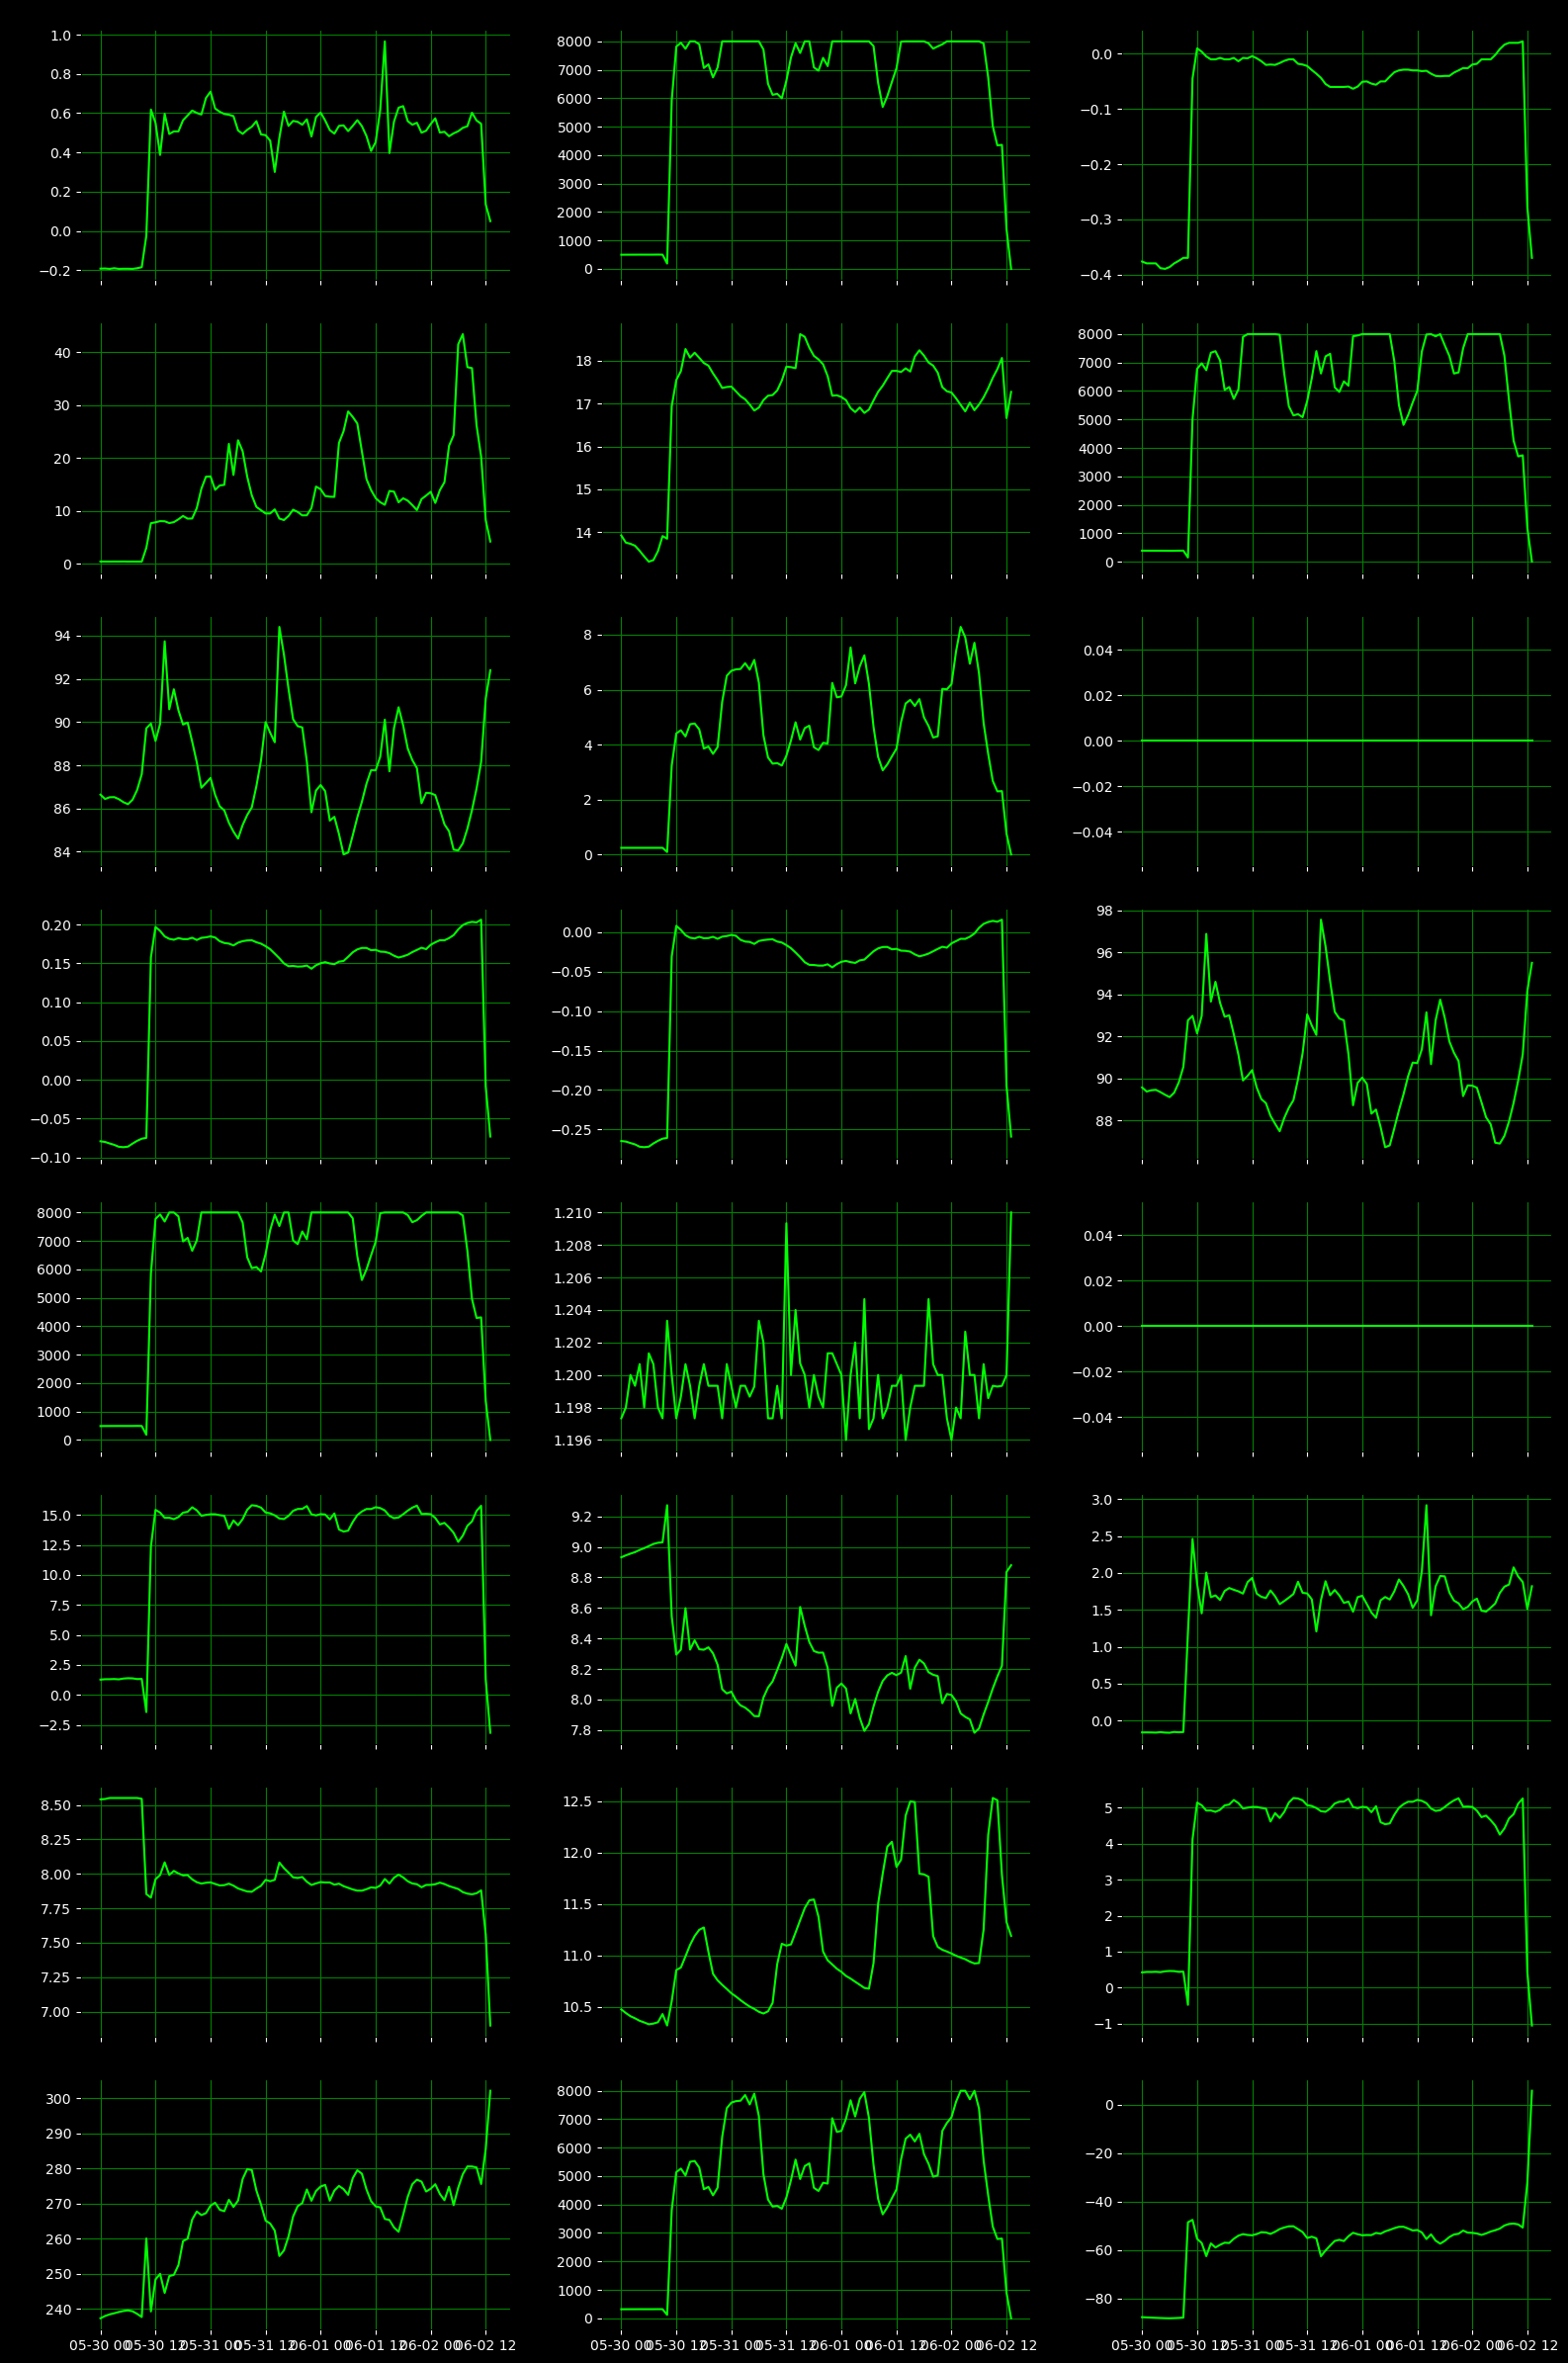

In [54]:
# fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 3 * rows), sharex=True)

# for i, var in enumerate(exo_plot_variables):
#     row = i // cols
#     col = i % cols
#     ax[row, col].plot(exo_hr.index, getattr(exo_hr, var), color='lime')  # Set line color to green
#     ax[row, col].set_ylabel('Units')  # Adjust units for each variable
#     ax[row, col].set_title(var)
#     ax[row, col].set_facecolor('black')  # Set background color to black
#     ax[row, col].tick_params(axis='x', colors='white')  # Set x-axis tick color to white
#     ax[row, col].tick_params(axis='y', colors='white')  # Set y-axis tick color to white
#     ax[row, col].grid(color='green')  # Set gridline color to green

# fig.patch.set_facecolor('black')  # Set background color outside the subplots to light gray
# plt.tight_layout()
# plt.show()

In [66]:
def fetch_data(start_date, end_date, month_num,month,year):
    # Generate URL based on the month
    url = f'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc1{month_num}{year}.txt.gz&dir=data/stdmet/{month}/'
  #      = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=dpxc162023.txt.gz&dir=data/stdmet/Jun/'

    # Read data from URL
    data = pd.read_csv(url,
                       header=[0],
                       na_values=('999.0', '99.0'),
                       skiprows=[1],
                       sep='\s+')
    
    # Extract and process time columns
    time = data.iloc[:, 0:5]
    time.columns = ['year', 'month', 'day', 'hour', 'minute']
    data_index = pd.to_datetime(time, format='stdmet')
    
    # Set index and filter by date range
    data = data.set_index(data_index)
    data = data.loc[start_date:end_date]
    
    # Filter and clean PRES column
    data['PRES'] = data['PRES'][data['PRES'] < 1500]
    
    # Resample for 30-minute averages
    data_hhr = data.resample('30MIN').mean()
    
    return data,data_hhr

# Example usage
start_date = '2023-05-30'
end_date = '2023-06-03'
year = 2023

davismay,davismay_hhr = fetch_data(start_date, end_date,5,'May',year)
davisjune,davisjune_hhr = fetch_data(start_date, end_date,6,'Jun',year)


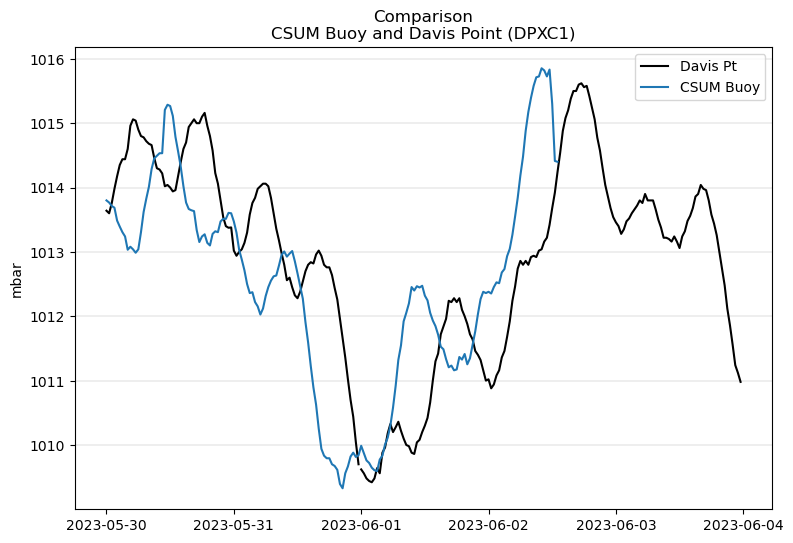

In [67]:
# compare data from Davis Point with the buoy
fig = plt.figure(figsize=(9,6))

plt.plot(davisjune_hhr.index,davisjune_hhr.PRES,color='k')
plt.plot(davismay_hhr.index,davismay_hhr.PRES,color='k',label='Davis Pt')
plt.plot(met_hhr.index,met_hhr.BP,label='CSUM Buoy')
plt.ylabel('mbar')
plt.grid(lw=0.3,axis='y')
plt.title('Comparison\nCSUM Buoy and Davis Point (DPXC1)')
plt.legend();